In [8]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.preprocessing import scale
import pandas as pd
from numpy import *
from scipy.stats import norm
import matplotlib.pyplot as plt

In [13]:
random.seed(123456)
N = 500
K = 4
features = random.randn(N,K-1)
features_probit = ones((N,K))
features_probit[:,1:K] = features
true_beta = array([-.12, .89, -.72, .50])
eps = random.randn(N)
Z0 = (matmul(features_probit,true_beta) + eps >0).astype(float)

xtrain, xtest, ztrain, ztest = train_test_split(features, Z0, test_size = 0.2, random_state=1)
ytrain = (ztrain>0).astype(float)
ytest = (ztest>0).astype(float)

X = ones((len(ytrain),K))
X[:,1:K] = xtrain
xtest_probit = ones((len(ytest),K))
xtest_probit[:,1:K] = xtest
Z = ztrain
Y= ytrain

nrep = 10000
burnin = 1000
# inverse of prior variance for beta
B0 = identity(K)*.01
xi = mean(X, axis = 0)
XX = matmul(transpose(X),X)
XX_inv = linalg.inv(XX)
pos = Y>0
neg = Y<=0
no_pos = sum(pos)
no_neg = sum(neg)
tau = 1
sig = linalg.inv(XX+B0)
beta = zeros((nrep,K))

In [14]:
# Gibb sampling
for i in range(1,nrep):
    b_mean = matmul(sig, tau*matmul(transpose(X),Z))
    beta[i,:] = random.multivariate_normal(b_mean, sig)
    mu = matmul(X,beta[i,:])
    # A and B are just some operations to simplify the operations pf Z
    A = ones(no_pos) - norm.cdf(-mu[pos])
    B = random.rand(no_pos)
    Z[pos] = norm.ppf(multiply(A,B) +norm.cdf(-mu[pos])) +mu[pos]
    A = random.rand(no_neg)
    B = norm.cdf(-mu[neg])
    Z[neg] = norm.ppf(multiply(A,B))+mu[neg]

In [15]:
mean(beta[burnin:nrep,:], axis = 0)

array([-0.14953115,  0.97407253, -0.70530793,  0.42341549])

In [16]:
std(beta[burnin:nrep,:], axis=0)

array([ 0.07926969,  0.09676043,  0.08872162,  0.08151307])

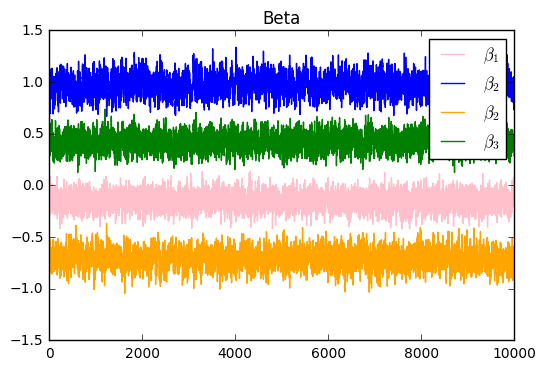

In [17]:
%matplotlib inline
plt.plot(beta[:,0], label=r'$\beta_1$', c='pink')
plt.plot(beta[:,1], label=r'$\beta_2$', c='blue')
plt.plot(beta[:,2], label=r'$\beta_2$', c='orange')
plt.plot(beta[:,3], label=r'$\beta_3$', c='green')
plt.title('Beta')
plt.legend()
plt.savefig('probit_sim.png')
plt.show()

In [20]:
b = mean(beta[burnin:nrep,:], axis = 0)
z_pred = matmul(xtest_probit,b)
y_pred = (z_pred>0).astype(float)
print("Correct classification", sum(y_pred==ytest)/len(ytest)*100, "%")

Correct classification 76.0 %


In [22]:
print("F1 score: ", f1_score(ytest, y_pred,average='binary'))

F1 score:  0.739130434783


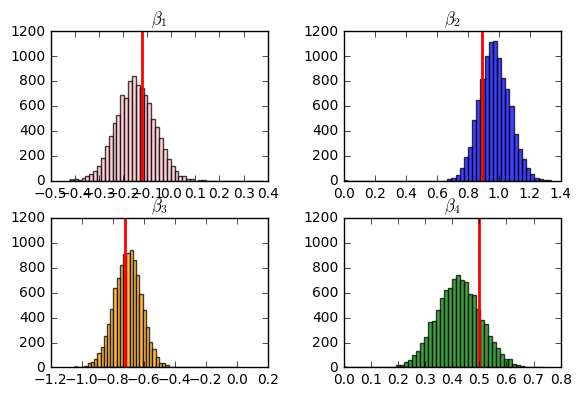

In [19]:
plt.figure(1)
numBins = 50

plt.subplot(221)
plt.hist(beta[:,0],numBins,color='pink',alpha=0.75)
plt.plot([-.12, -.12],[0, 1200],color='red', linewidth=2.0)
plt.title(r'$\beta_1$')

plt.subplot(222)
plt.hist(beta[:,1],numBins,color='blue',alpha=0.75)
plt.plot([.89, .89],[0, 1200],color='red', linewidth=2.0)
plt.title(r'$\beta_2$')

plt.subplot(223)
plt.hist(beta[:,2],numBins,color='orange',alpha=0.75)
plt.plot([-.72, -.72],[0, 1200],color='red', linewidth=2.0)
plt.title(r'$\beta_3$')

plt.subplot(224)
plt.hist(beta[:,3],numBins,color='green',alpha=0.75)
plt.plot([.50, .50],[0, 1200],color='red', linewidth=2.0)
plt.title(r'$\beta_4$')

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, 
                    wspace=0.35)
plt.savefig('probit_sim2.png')
plt.show()

In [21]:
clf = GaussianNB()
y_pred2 = clf.fit(xtrain, ytrain).predict(xtest)
print("Correct classification", sum(y_pred2==ytest)/len(ytest)*100, "%")

Correct classification 72.0 %


In [23]:
print("F1 score: ", f1_score(ytest, y_pred2,average='binary'))

F1 score:  0.702127659574
